# Amplitude of seasonal cycle (by season)

- use the mmm dataset 
- group the data by season
- take the amplitude of the seasoal cycle (Tmax-Tmin) for each grid point (for mmm)
- select out regions and take llm
- plot time series of seasonal cycle for each region 

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration
import seaborn as sns
import scipy.stats # to calculate correlation

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

## read in 20CR data

In [3]:
path_tmp = '/g/data/w48/kb6999/20CR_TMP_raw_data_for_plots/'
path_pr = '/g/data/w48/kb6999/20CR_PRATE_raw_data_for_plots/'

In [4]:
# mmm but not llm
mmm_raw_glob_pr = xr.open_dataset(f'{path_pr}mmm_raw_glob.nc')
mmm_raw_glob_pr

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, time: 1992)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
Data variables:
    pr       (time, lat, lon) float64 ...

In [5]:
# mmm but not llm
mmm_raw_glob_tmp = xr.open_dataset(f'{path_tmp}mmm_raw_glob.nc')
mmm_raw_glob_tmp

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, time: 1992)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
  * lon      (lon) float32 0.0 0.703 1.406 2.109 ... 357.1 357.8 358.5 359.2
  * lat      (lat) float32 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
Data variables:
    tmp      (time, lat, lon) float32 ...

In [29]:
# group the raw data by season
mmm_seasonal_glob_pr = func.seasonal_group(mmm_raw_glob_pr)
mmm_seasonal_glob_pr
mmm_seasonal_glob_tmp = func.seasonal_group(mmm_raw_glob_tmp)
mmm_seasonal_glob_tmp

<xarray.Dataset>
Dimensions:     (lat: 256, lon: 512, season: 4, seasonyear: 167)
Coordinates:
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * lon         (lon) float32 0.0 0.703 1.406 2.109 ... 357.1 357.8 358.5 359.2
  * lat         (lat) float32 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
  * seasonyear  (seasonyear) int64 1850 1851 1852 1853 ... 2013 2014 2015 2016
Data variables:
    tmp         (seasonyear, season, lat, lon) float32 -0.3049 -0.3048 ... nan

In [42]:
season_amp_pr = func.seasonal_amp(mmm_seasonal_glob_pr).sel(seasonyear=slice('1850','2015'))
season_amp_tmp = func.seasonal_amp(mmm_seasonal_glob_tmp).sel(seasonyear=slice('1850','2015'))

In [35]:
# import landmask dataset 
landfrac_ds_tmp = xr.open_dataset('/g/data/w48/kb6999/20CR_data_netcdfs/land_20CR.nc')
landmask_tmp = landfrac_ds_tmp
landfrac_ds_pr = xr.open_dataset('/g/data/w48/kb6999/20CR_data_netcdfs/land_pr_20CR.nc')
landmask_pr = landfrac_ds_pr

In [47]:
#PRATE 
# Select out SH and NH anomalies 
season_amp_SH_pr = season_amp_pr.sel(lat=slice(0,-90)) 
season_amp_NH_pr = season_amp_pr.sel(lat=slice(90,0)) 
# select out the Australian and E Australian anomalies 
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    season_amp_Aus_pr = season_amp_pr.sel(lat=slice(-10,-50), lon=slice(110,160)).where(landmask_pr.LAND==1.0, drop=True)
    season_amp_EA_pr = season_amp_pr.sel(lat=slice(-10,-50), lon=slice(140,155)).where(landmask_pr.LAND==1.0, drop=True)

In [36]:
# Select out SH and NH anomalies 
season_amp_SH_tmp = season_amp_tmp.sel(lat=slice(0,-90)) 
season_amp_NH_tmp = season_amp_tmp.sel(lat=slice(90,0)) 
# select out the Australian and E Australian anomalies 
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    season_amp_Aus_tmp = season_amp_tmp.sel(lat=slice(-10,-50), lon=slice(110,160)).where(landmask_tmp.LAND==1.0, drop=True)
    season_amp_EA_tmp = season_amp_tmp.sel(lat=slice(-10,-50), lon=slice(140,155)).where(landmask_tmp.LAND==1.0, drop=True)

In [49]:
# take the lat lon mean and combine precipitation and temperature into one dataset
season_amp_Glob = xr.Dataset({'tmp': season_amp_tmp.mean(dim=['lat','lon']).tmp, 'pr': season_amp_pr.mean(dim=['lat','lon']).pr})
season_amp_SH = xr.Dataset({'tmp': season_amp_SH_tmp.mean(dim=['lat','lon']).tmp, 'pr': season_amp_SH_pr.mean(dim=['lat','lon']).pr})
season_amp_NH = xr.Dataset({'tmp': season_amp_NH_tmp.mean(dim=['lat','lon']).tmp, 'pr': season_amp_NH_pr.mean(dim=['lat','lon']).pr})
season_amp_Aus = xr.Dataset({'tmp': season_amp_Aus_tmp.mean(dim=['lat','lon']).tmp, 'pr': season_amp_Aus_pr.mean(dim=['lat','lon']).pr})
season_amp_EA = xr.Dataset({'tmp': season_amp_EA_tmp.mean(dim=['lat','lon']).tmp, 'pr': season_amp_EA_pr.mean(dim=['lat','lon']).pr})

## figures

In [38]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [39]:
fplot = reload(fplot)

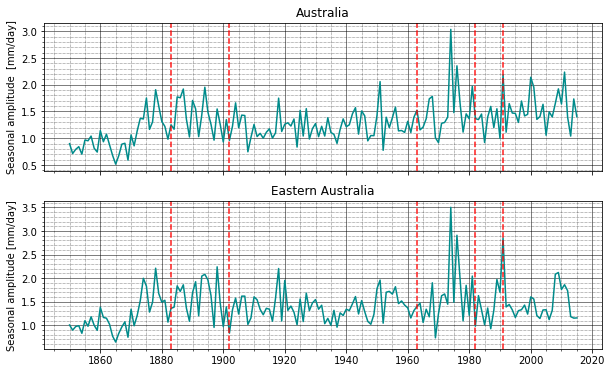

In [51]:
# Monthly temperature seasonal cycle amplitude stacked
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,6)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_noP(season_amp_Aus.pr, ax = axes[0], color='darkcyan')
    fplot.timeseries_noP(season_amp_EA.pr, ax = axes[1], color='darkcyan')

axes[0].set(ylabel= f'Seasonal amplitude  [mm/day]', title = 'Australia')
axes[1].set(ylabel= f'Seasonal amplitude [mm/day]', title = 'Eastern Australia')

# set xticks and labels
axes[1].set_xticks(np.arange(min(season_amp_Aus.seasonyear)+10, max(season_amp_Aus.seasonyear)+11, 20))

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_s_seasonal_amp_pr_Aus_EA.png', dpi=300, bbox_inches='tight')

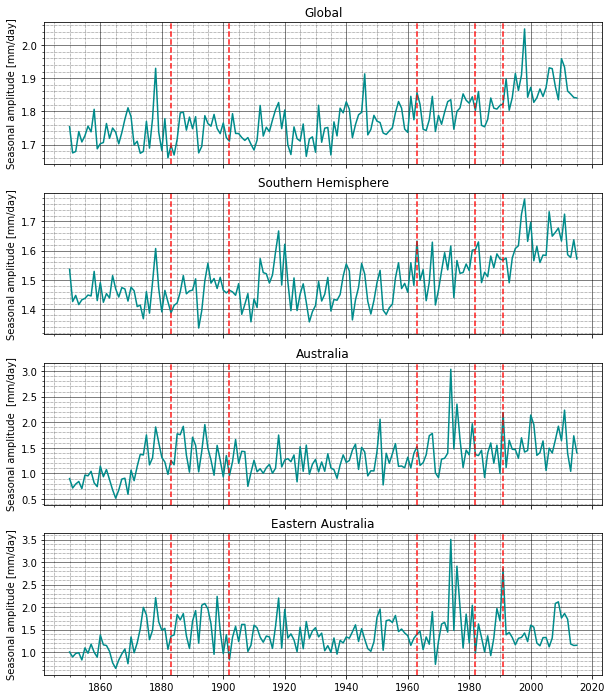

In [52]:
# Monthly temperature seasonal cycle amplitude stacked
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_noP(season_amp_Glob.pr, ax = axes[0], color='darkcyan')
    fplot.timeseries_noP(season_amp_SH.pr, ax = axes[1], color='darkcyan')
    fplot.timeseries_noP(season_amp_Aus.pr, ax = axes[2], color='darkcyan')
    fplot.timeseries_noP(season_amp_EA.pr, ax = axes[3], color='darkcyan')

axes[0].set(ylabel= f'Seasonal amplitude [mm/day]', title = 'Global') 
axes[1].set(ylabel= f'Seasonal amplitude [mm/day]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Seasonal amplitude  [mm/day]', title = 'Australia')
axes[3].set(ylabel= f'Seasonal amplitude [mm/day]', title = 'Eastern Australia')

# set xticks and labels
axes[3].set_xticks(np.arange(min(season_amp_Glob.seasonyear)+10, max(season_amp_Glob.seasonyear)+11, 20))

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_s_seasonal_amp_pr_stacked.png', dpi=300, bbox_inches='tight')

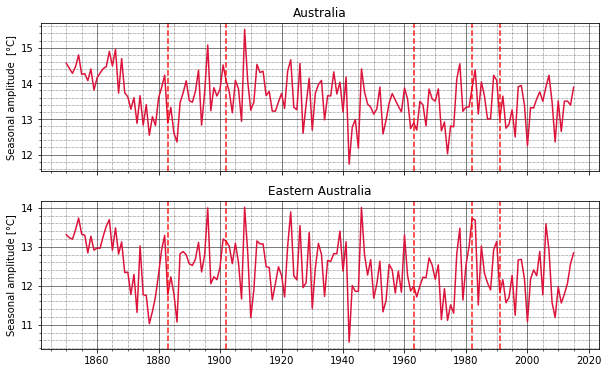

In [66]:
# Monthly temperature seasonal cycle amplitude stacked
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,6)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_noP(season_amp_Aus.tmp, ax = axes[0], color='crimson')
    fplot.timeseries_noP(season_amp_EA.tmp, ax = axes[1], color='crimson')

axes[0].set(ylabel= f'Seasonal amplitude  [{deg}C]', title = 'Australia')
axes[1].set(ylabel= f'Seasonal amplitude [{deg}C]', title = 'Eastern Australia')

# set xticks and labels
axes[1].set_xticks(np.arange(min(season_amp_Aus.seasonyear)+10, max(season_amp_Aus.seasonyear)+11, 20))

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_s_seasonal_amp_tmp_Aus_EA.png', dpi=300, bbox_inches='tight')

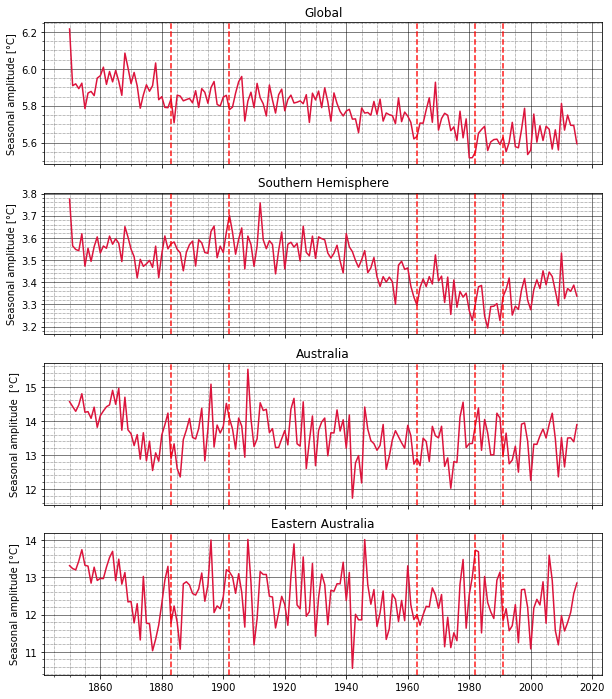

In [67]:
# Monthly temperature seasonal cycle amplitude stacked
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_noP(season_amp_Glob.tmp, ax = axes[0], color='crimson')
    fplot.timeseries_noP(season_amp_SH.tmp, ax = axes[1], color='crimson')
    fplot.timeseries_noP(season_amp_Aus.tmp, ax = axes[2], color='crimson')
    fplot.timeseries_noP(season_amp_EA.tmp, ax = axes[3], color='crimson')

axes[0].set(ylabel= f'Seasonal amplitude [{deg}C]', title = 'Global') 
axes[1].set(ylabel= f'Seasonal amplitude [{deg}C]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Seasonal amplitude  [{deg}C]', title = 'Australia')
axes[3].set(ylabel= f'Seasonal amplitude [{deg}C]', title = 'Eastern Australia')

# set xticks and labels
axes[3].set_xticks(np.arange(min(season_amp_Glob.seasonyear)+10, max(season_amp_Glob.seasonyear)+11, 20))

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_s_seasonal_amp_tmp_stacked.png', dpi=300, bbox_inches='tight')

## combined plots

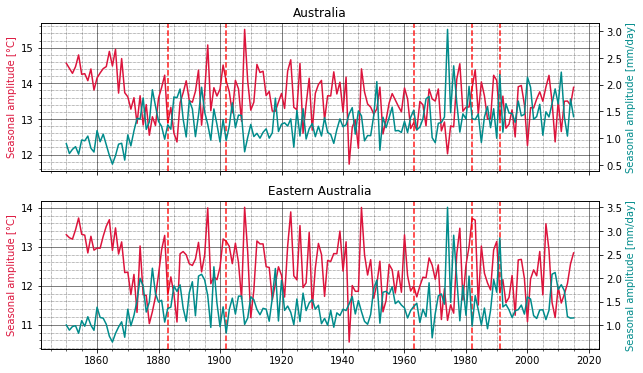

In [65]:
# Monthly temperature seasonal cycle amplitude stacked
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,6)) # make a figure

color_ax1 = 'crimson'
color_ax2 = 'darkcyan'

label_ax1 = 'tmp'
label_ax2 = 'pr'


with dask.diagnostics.ProgressBar():
    fplot.timeseries_noP(season_amp_Aus.tmp, ax = axes[0], color= color_ax1, label = label_ax1)
    fplot.timeseries_noP(season_amp_EA.tmp, ax = axes[1], color= color_ax1, label = label_ax1)
    
        # set the colour of the first axis label
    axes[0].set_ylabel(f'Seasonal amplitude [{deg}C]', color=color_ax1)
    ax2_0 = axes[0].twinx()
    season_amp_Aus.pr.plot(ax=ax2_0, color=color_ax2, label = label_ax2)
    ax2_0.set_ylabel(f'Seasonal amplitude [mm/day]', color=color_ax2)
    
        # set the colour of the first axis label
    axes[1].set_ylabel(f'Seasonal amplitude [{deg}C]', color=color_ax1)
    ax2_0 = axes[1].twinx()
    season_amp_EA.pr.plot(ax=ax2_0, color=color_ax2, label = label_ax2)
    ax2_0.set_ylabel(f'Seasonal amplitude [mm/day]', color=color_ax2)
    
# set axes titles 
axes[0].set(title = 'Australia')
axes[1].set(title = 'Eastern Australia')

# set xticks and labels
axes[1].set_xticks(np.arange(min(season_amp_Glob.seasonyear)+10, max(season_amp_Glob.seasonyear)+11, 20))

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_s_seasonal_amp_pr+tmp_Aus+EA.png', dpi=300, bbox_inches='tight')

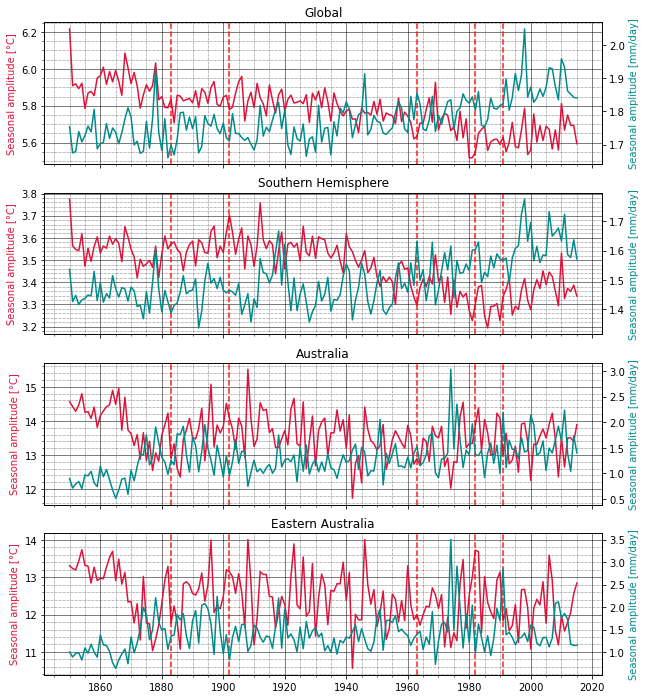

In [62]:
# Monthly temperature seasonal cycle amplitude stacked
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

color_ax1 = 'crimson'
color_ax2 = 'darkcyan'

label_ax1 = 'tmp'
label_ax2 = 'pr'


with dask.diagnostics.ProgressBar():
    fplot.timeseries_noP(season_amp_Glob.tmp, ax = axes[0], color= color_ax1, label = label_ax1)
    fplot.timeseries_noP(season_amp_SH.tmp, ax = axes[1], color= color_ax1, label = label_ax1)
    fplot.timeseries_noP(season_amp_Aus.tmp, ax = axes[2], color= color_ax1, label = label_ax1)
    fplot.timeseries_noP(season_amp_EA.tmp, ax = axes[3], color= color_ax1, label = label_ax1)
    
    # set the colour of the first axis label
    axes[0].set_ylabel(f'Seasonal amplitude [{deg}C]', color=color_ax1)
    ax2_0 = axes[0].twinx()
    season_amp_Glob.pr.plot(ax=ax2_0, color=color_ax2, label = label_ax2)
    ax2_0.set_ylabel(f'Seasonal amplitude [mm/day]', color=color_ax2)
#     axes[0].legend(loc='lower left')
    
        # set the colour of the first axis label
    axes[1].set_ylabel(f'Seasonal amplitude [{deg}C]', color=color_ax1)
    ax2_0 = axes[1].twinx()
    season_amp_SH.pr.plot(ax=ax2_0, color=color_ax2, label = label_ax2)
    ax2_0.set_ylabel(f'Seasonal amplitude [mm/day]', color=color_ax2)
    
        # set the colour of the first axis label
    axes[2].set_ylabel(f'Seasonal amplitude [{deg}C]', color=color_ax1)
    ax2_0 = axes[2].twinx()
    season_amp_Aus.pr.plot(ax=ax2_0, color=color_ax2, label = label_ax2)
    ax2_0.set_ylabel(f'Seasonal amplitude [mm/day]', color=color_ax2)
    
        # set the colour of the first axis label
    axes[3].set_ylabel(f'Seasonal amplitude [{deg}C]', color=color_ax1)
    ax2_0 = axes[3].twinx()
    season_amp_EA.pr.plot(ax=ax2_0, color=color_ax2, label = label_ax2)
    ax2_0.set_ylabel(f'Seasonal amplitude [mm/day]', color=color_ax2)
    
# set axes titles 
axes[0].set(title = 'Global') 
axes[1].set(title = 'Southern Hemisphere')
axes[2].set(title = 'Australia')
axes[3].set(title = 'Eastern Australia')

# set xticks and labels
axes[3].set_xticks(np.arange(min(season_amp_Glob.seasonyear)+10, max(season_amp_Glob.seasonyear)+11, 20))

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_s_seasonal_amp_pr+tmp_stacked.png', dpi=300, bbox_inches='tight')